<h1>Final Project - 
Diagnosing Glaucoma via retinal images: A Deep Learning Approach</h1>
<b>Project template:</b> CM3150 Machine Learning and Neural Networks: Deep Learning on a public dataset

<i>Mohammad Saiful Islam</i>

<h2>The problem and datasets chosen</h2>
The goal of this prototype is to build a working Deep Learning (DL) model that can distinguish between non-glaucoma and glaucoma-positive retinal images for Glaucoma diagnosis. Thus, it is a binary classification problem. 

This problem is currently under research in many medical and research institutes as the fully optimal DL model that is accessible, highly accurate, interpretable, and clinically accepted has not yet appeared in the medical world. 

Current researches make use of both color fundus images (2D) and Optical Coherence Tomography (3D) imaging. However, in this prototype, I will be using color fundus images for ensuring accessibility and cost-effectiveness. I will train on multiple neural network architectures for understanding the best performing model which can distinguish between Glaucoma positive and normal images.

<h4>Datasets</h4>
1. I will use a modified (cleaned) version of the EyePACS AIROGS dataset [1], EyePACS-AIROGS-light-V2 [2]. The dataset has two classes: RG (Referable Glaucoma: 4K training samples) and NRG (Non referable Glaucoma:4K training samples)
<br>
2. DRISHTI-GS: 101 images
<br>
3. BEH: 463 No-Glaucoma + 171 Glaucoma-positive
<br>
4. Datasets from ORIGA (650 images) and G1020 (1020 images)
<br>
5. Fives dataset (contains multiple diseases among which Glaucoma is present).

<h4> External dataset for external evaluation</h4>
Venu Eye Institute and Research Centre (VEIRC) Glaucoma dataset 

<h2>Measures of success</h2>
The models would be evaluated with a range of metrics such as precision, recall (sensitivity), Area under the ROC Curve. Confusion matrix will also be used to understand the best performing model.

<h2>Evaluation protocol</h2>
The dataset will be divided into train, test, and validation sets.
I will use a hold out set for validation during the training. Then, I will perfrom and internal testing using the test data separated earlier. For further generalization checks, I will also get another totally unseen dataset and perform an external testing and check the performance of the models on the unseen data.

<h2>Data preparation</h2>

I wanted to use the original Rotterdam EyePACS AIROGS dataset is not machine-learning ready yet. A couple of days ago, a cleansed version (small subset) of the same dataset (Glaucoma Dataset: EyePACS-AIROGS-light-V2) was uploaded on Kaggle [2]. The author mentions in the data card section that: "One of the largest drawbacks of the original dataset is the accessibility of the dataset. The dataset requires a long download, a large storage space, it spans several folders, and it is not machine-learning-ready (it requires data processing and splitting). The dataset also contains raw fundus images in their original dimensions; these original images often contain a large amount of black background and the dimensions are too large for machine learning inputs. The proposed dataset addresses the aforementioned concerns by image sampling and image standardization to balance and reduce the dataset size respectively."

After analyzing both the original and the refined datasets, I found out that the current posted original dataset [1] has only 3270 Glaucoma-positive images. Thus, there is no need for doing that process again. However, I would need to preprocess the rest of the datasets. 

The preprocessing includes cropping the black portions and resizing both as we don't want to disturb the details of the fundus image. Not changing the aspect ratio is also important.

1. First, I will crop the black portions out. 
2. Then, I will resize and pad the image to make sure that the aspect ratio is kept intact. The size will be 512*512

In [1]:
# import dependencies
import tensorflow as tf
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers, regularizers, optimizers, metrics
import pandas as pd
from PIL import Image
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import cv2
import os
import shutil
from tqdm import tqdm
import numpy as np
from datasets import load_metric
import torch

import matplotlib.pyplot as plt


2024-02-19 23:04:05.423563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 23:04:05.445891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 23:04:05.445910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 23:04:05.446456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 23:04:05.450261: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# function for processing images
def process_image(input_path, output_path):
    # Load the image
    image = Image.open(input_path)
    image_array = np.array(image)
    # if np.min(max_vals_start) < 5 or np.min(max_vals_end) < 5:
    # convert the image to grayscale
    if image_array.ndim == 2:
        # create 3 dimensional numpy array if original image is gray.
        # this is needed for tensorflow resize function
        image_array = cv2.cvtColor(image_array,cv2.COLOR_GRAY2RGB)

    gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    # apply thresholding to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, 5, 255,
                                   cv2.THRESH_BINARY)
    # find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)
    # find the bounding box of the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Crop the image using the bounding box
        img_crop = image_array[y:y+h, x:x+w]

    else:
        # If no contours are found, use the entire image
        img_crop = image_array

    # Resize to 512*512 pixels
    resized_image = tf.image.resize_with_pad(img_crop, 512, 512)
        
    # Save the processed image
    processed_image = Image.fromarray(np.uint8(resized_image))
    processed_image.save(output_path)


What the above function does it, it takes the image path, processes it:
1. Check if the image has large black portions by checking the first 100 pixels. If it does have, then it is processed using OpenCV to find the largest contour and use its corresponding bounding box to output the new cropped image.

<h3>Creating directories and processing images</h3>

Since datasets come in different file organizing conventions, I would first create a collective folder for storing the preprocessed images.

In [3]:
# check if directory exists
import os
final_dataset_path = "/home/drmohammad/Documents/final-glaucoma/FINAL_DATASET"
# Check whether the specified path exists or not
isExist = os.path.exists(final_dataset_path)
if not isExist:
   # Create a new directory because it does not exist
    os.makedirs(final_dataset_path)
    os.makedirs(os.path.join(final_dataset_path, "normal"))
    os.makedirs(os.path.join(final_dataset_path, "glaucoma"))


<h3>Dataset 1: EyePACS-AIROGS-light-V2</h3>

Since the dataset is already preprocessed, I will import it as it is. It is already separated into train, test, and validation sets. Here in this dataset: RG means Glaucoma-positive and NRG means normal.

In [247]:
train_eyepacs_dir = os.path.join("/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg", 'train')
val_eyepacs_dir = os.path.join("/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg", 'validation')
test_eyepacs_dir = os.path.join("/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg", 'test')

<h3>Dataset 2: DRISHTI-GS</h3>

The DRISHTI-GS dataset is divided into two folders: training and testing. I will have to separate them according to class and store them in a folder that contains two subfolders: normal and glaucoma.
The dataset has the labels in an excel sheet. Thus, we have to read the excel file and extract the information and store in corresponding label folder.

In [248]:
# read excel file
drishti_labels_df = pd.read_excel("Drishti-GS1_files/Drishti-GS1_diagnosis.xlsx")
# the columns are in the third row.
drishti_labels_df.columns = drishti_labels_df.iloc[2]
# drop extra rows
drishti_labels_df = drishti_labels_df.drop([0,1,2,3])
# there were some extra apostrophes which needed removal
drishti_labels_df['Drishti-GS File'] = drishti_labels_df['Drishti-GS File'].str.replace("'", '')
drishti_labels_df
# normal_images_2 = os.path.join("/home/drmohammad/Documents/final-glaucoma/RIM-ONE_DL_images/partitioned_randomly/training_set", 'training_set')

2,NaN,Drishti-GS File,Patient ID,Marking 1,Marking 2,Marking 3,Marking 4,Additional Expert,Total
4,NaN,drishtiGS_001,1077987,-1,-1,1,1,1,Glaucomatous
5,NaN,drishtiGS_002,1167573,1,1,1,1,1,Glaucomatous
6,NaN,drishtiGS_003,1393265,1,1,1,1,1,Glaucomatous
7,NaN,drishtiGS_004,1393265,1,1,-1,1,1,Glaucomatous
8,NaN,drishtiGS_005,1481925,1,1,1,1,1,Glaucomatous
...,...,...,...,...,...,...,...,...,...
100,NaN,drishtiGS_097,2864821,-1,-1,-1,-1,-1,Normal
101,NaN,drishtiGS_098,2864821,-1,-1,-1,1,-1,Normal
102,NaN,drishtiGS_099,2864831,-1,-1,-1,-1,-1,Normal
103,NaN,drishtiGS_100,2864841,-1,-1,-1,-1,-1,Normal


Let's first separate and preprocess the training set that was in the DRISHTI original dataset.

In [250]:
training_drishti_path = "Drishti-GS1_files/Drishti-GS1_files/Training/Images"
testing_drishti_path = "Drishti-GS1_files/Drishti-GS1_files/Test/Images"

# iterate over files in
# that directory
for filename in tqdm(os.listdir(training_drishti_path)):
    f = os.path.join(training_drishti_path, filename)
    if os.path.isfile(f):
        # get class from Total column
        class_img = drishti_labels_df.loc[drishti_labels_df["Drishti-GS File"] == \
                        filename.split(".")[0]]["Total"].astype("string").item()
        if class_img == "Glaucomatous":
            folder_name = "glaucoma"
        else:
            folder_name = "normal"
        dst = f"{final_dataset_path}/{folder_name}/{filename}"
        # copy file to collective folder
        shutil.copyfile(f, dst)
        # process the image
        process_image(f, dst)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.52it/s]


Now for the testing data. 

In [251]:
for filename in tqdm(os.listdir(testing_drishti_path)):
    f = os.path.join(testing_drishti_path, filename)
    if os.path.isfile(f):
        # get class from Total column
        class_img = drishti_labels_df.loc[drishti_labels_df["Drishti-GS File"] == \
                        filename.split(".")[0]]["Total"].astype("string").item()
        if class_img == "Glaucomatous":
            folder_name = "glaucoma"
        else:
            folder_name = "normal"
        dst = f"{final_dataset_path}/{folder_name}/{filename}"
        # copy file to collective folder
        shutil.copyfile(f, dst)
        # process copied image
        process_image(f, dst)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.65it/s]


Now we don't have anything called training or testing set yet. We will create them after we have preprocessed and separated all images into its respective classes.

<h3>Dataset 3: BEH</h3>

The Bangladesh Eye Hospital Dataset is already separated into two subfolders: glaucoma and normal. However, the dataset needs preprocessing. Let's preprocess and move them to our final dataset folders.

In [252]:
beh_glaucoma_path = "/home/drmohammad/Documents/final-glaucoma/BEH (Bangladesh Eye Hospital) Dataset/BEH (Bangladesh Eye Hospital) Dataset/glaucoma"
beh_normal_path = "/home/drmohammad/Documents/final-glaucoma/BEH (Bangladesh Eye Hospital) Dataset/BEH (Bangladesh Eye Hospital) Dataset/normal"

Move Glaucoma-positive images to our collective directory and process them.

In [253]:
for filename in tqdm(os.listdir(beh_glaucoma_path)):
    f = os.path.join(beh_glaucoma_path, filename)
    if os.path.isfile(f) and f.endswith(".JPG"):
        dst = f"{final_dataset_path}/glaucoma/{filename}"
        process_image(f, dst)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:06<00:00, 27.88it/s]


Move Glaucoma-negative (normal) images to our collective directory and process them.

In [254]:
for filename in tqdm(os.listdir(beh_normal_path)):
    f = os.path.join(beh_normal_path, filename)
    if os.path.isfile(f) and f.endswith(".JPG"):
        dst = f"{final_dataset_path}/normal/{filename}"
        process_image(f, dst)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463/463 [00:16<00:00, 27.90it/s]


<h3>Dataset 4: Datasets from ORIGA, and G1020</h3>

We have two more datasets (from one kaggle dataset) that I will add to the existing dataset. Lets start by the ORIGA dataset. Here in the CSV, normal is labeled as 0 and glaucoma-positive is labeled as 1.

In [255]:
# read csv file
origa_labels_df = pd.read_csv("multipledatasets/ORIGA/origa_info.csv")
# get the image file stripped of full path
origa_labels_df['Image'] = origa_labels_df['Image'].str.split("/").str[-1]
origa_labels_df

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
0,001.jpg,Origa,True,0.7097,0.636027,0.580909,0
1,002.jpg,Origa,True,0.6953,0.575024,0.608413,0
2,003.jpg,Origa,True,0.9629,0.299303,0.262828,0
3,004.jpg,Origa,True,0.7246,0.503186,0.483273,0
4,005.jpg,Origa,True,0.6138,0.500141,0.283467,0
...,...,...,...,...,...,...,...
645,646.jpg,Origa,True,0.6560,0.123190,0.264288,1
646,647.jpg,Origa,True,0.7365,0.602515,0.528356,1
647,648.jpg,Origa,True,0.5101,0.295414,0.549101,1
648,649.jpg,Origa,True,0.5227,0.624191,0.383839,0


Lets now copy the images to our required structure (in the collective folder) by using the Label column to check an image's class.

In [256]:
origa_path = "multipledatasets/ORIGA/Images"

# iterate over files in
# that directory
for filename in tqdm(os.listdir(origa_path)):
    f = os.path.join(origa_path, filename)
    if os.path.isfile(f):
        # get corresponding class from Label column
        class_img = origa_labels_df.loc[origa_labels_df["Image"] == \
                        filename]["Label"].astype("string").item()
        # get folder names based on class
        if class_img == "1":
            folder_name = "glaucoma"
        elif class_img == "0":
            folder_name = "normal"
        else:
            raise "Error"
        dst = f"{final_dataset_path}/{folder_name}/{filename}"
        
        # copy file to collective folder
        shutil.copyfile(f, dst)
        # process image
        process_image(f, dst)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:20<00:00, 31.49it/s]


Now, let's do the same for G1020 dataset.

In [257]:
g1020_labels_df = pd.read_csv("multipledatasets/G1020/G1020.csv")

g1020_labels_df

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0
...,...,...
1015,image_3198.jpg,0
1016,image_3199.jpg,0
1017,image_3201.jpg,1
1018,image_3202.jpg,1


In [258]:
g1020_path = "multipledatasets/G1020/Images"

# iterate over files in
# that directory
for filename in tqdm(os.listdir(g1020_path)):
    f = os.path.join(g1020_path, filename)
    if os.path.isfile(f) and f.endswith(".jpg"):
        # get corresponding class from binaryLabels column
        class_img = g1020_labels_df.loc[g1020_labels_df["imageID"] == \
                        filename]["binaryLabels"].astype("string").item()
        if class_img == "1":
            folder_name = "glaucoma"
        elif class_img == "0":
            folder_name = "normal"
        else:
            raise "Error"
        dst = f"{final_dataset_path}/{folder_name}/{filename}"
        # copy and process image
        shutil.copyfile(f, dst)
        process_image(f, dst)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:40<00:00, 50.92it/s]


<h3>Dataset 5: FIVES dataset</h3>

This dataset has data separated into train and test folders. Moreover, the labels of the images are already in the filename. the files ending with _G are glaucoma positive. The files ending with _N are normal.

In [379]:
fives_train_path = "FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original"
fives_test_path = "FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original"

# list for storing the train and test paths
path_list = [fives_train_path, fives_test_path]
for path in path_list:
    for filename in tqdm(os.listdir(path)):
        f = os.path.join(path, filename)
        if os.path.isfile(f) and f.endswith(".png"):
            # get stripped filename without path
            stripped_filename = filename.split(".")[0]
            # get class name
            class_img = stripped_filename.split("_")[1]
            if class_img == "G":
                folder_name = "glaucoma"
            elif class_img == "N":
                folder_name = "normal"
            else:
                # if class is other than G or N, then we go to the next image
                continue
            dst = f"{final_dataset_path}/{folder_name}/{filename}"
            
            # copy and process image
            shutil.copyfile(f, dst)
            process_image(dst, dst)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 16.79it/s]


<h3>Prepare final folder for training, testing and validation</h3>

Now this collective folder contains all images from datasets 2 to 5. Now I will create another folder that will contain all 5 datasets. 

Lets see the number of images from datasets 2 to 5 (both inclusive)

In [4]:
print('Glaucoma-positive images (excluding the eyepacs-v2 dataset):', len(os.listdir(os.path.join(final_dataset_path, "glaucoma"))))

Glaucoma-positive images (excluding the eyepacs-v2 dataset): 905


In [5]:
print('Normal images (excluding the eyepacs-v2 dataset):', len(os.listdir(os.path.join(final_dataset_path, "normal"))))

Normal images (excluding the eyepacs-v2 dataset): 1900


Now, lets create the final collective data structure and folders.

In [4]:
# create main directories
final_data_dir = '/home/drmohammad/Documents/final-glaucoma/data'
if not os.path.exists(final_data_dir):
    os.mkdir(final_data_dir)

# train directories
train_dir = os.path.join(final_data_dir, 'train')
train_glaucoma_dir = os.path.join(train_dir, 'glaucoma')
train_normal_dir = os.path.join(train_dir, 'normal')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    os.mkdir(train_glaucoma_dir)
    os.mkdir(train_normal_dir)

# validation directories    
val_dir = os.path.join(final_data_dir, 'validation')
val_glaucoma_dir = os.path.join(val_dir, 'glaucoma')
val_normal_dir = os.path.join(val_dir, 'normal')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)
    os.mkdir(val_glaucoma_dir)
    os.mkdir(val_normal_dir)

# test directories    
test_dir = os.path.join(final_data_dir, 'test')
test_glaucoma_dir = os.path.join(test_dir, 'glaucoma')
test_normal_dir = os.path.join(test_dir, 'normal')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    os.mkdir(test_glaucoma_dir)
    os.mkdir(test_normal_dir)



This is a dataset that is going to be used for external evaluation. Details are in the report.

In [1]:
external_test_dir = "/home/drmohammad/Downloads/test_india/"

Let's move dataset 1: Eyepacs-Light-V2 dataset as it is to the train-test-validation folders.

In [383]:
# copy glaucoma-positive train images
train_eyepacs_RG_path = os.path.join(train_eyepacs_dir, "RG")
for filename in tqdm(os.listdir(train_eyepacs_RG_path)):
    f = os.path.join(train_eyepacs_RG_path, filename)
    if os.path.isfile(f):
        
        dst = f"{train_glaucoma_dir}/{filename}"
        
        shutil.copyfile(f, dst)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 17921.26it/s]


In [384]:
# copy glaucoma-negative (normal) train images
train_eyepacs_NRG_path = os.path.join(train_eyepacs_dir, "NRG")
for filename in tqdm(os.listdir(train_eyepacs_NRG_path)):
    f = os.path.join(train_eyepacs_NRG_path, filename)
    if os.path.isfile(f):
        
        dst = f"{train_normal_dir}/{filename}"
        
        shutil.copyfile(f, dst)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 17732.03it/s]


In [385]:
# copy glaucoma-positive test images
test_eyepacs_RG_path = os.path.join(test_eyepacs_dir, "RG")
for filename in tqdm(os.listdir(test_eyepacs_RG_path)):
    f = os.path.join(test_eyepacs_RG_path, filename)
    if os.path.isfile(f):
        
        dst = f"{test_glaucoma_dir}/{filename}"
        
        shutil.copyfile(f, dst)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 16986.88it/s]


In [386]:
# copy glaucoma-negative (normal) test images
test_eyepacs_NRG_path = os.path.join(test_eyepacs_dir, "NRG")
for filename in tqdm(os.listdir(test_eyepacs_NRG_path)):
    f = os.path.join(test_eyepacs_NRG_path, filename)
    if os.path.isfile(f):
        
        dst = f"{test_normal_dir}/{filename}"
        
        shutil.copyfile(f, dst)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 16565.35it/s]


In [387]:
print(val_eyepacs_dir)
# copy glaucoma-positive validation images
val_eyepacs_RG_path = os.path.join(val_eyepacs_dir, "RG")
for filename in tqdm(os.listdir(val_eyepacs_RG_path)):
    f = os.path.join(val_eyepacs_RG_path, filename)
    if os.path.isfile(f):
        
        dst = f"{val_glaucoma_dir}/{filename}"
        
        shutil.copyfile(f, dst)

/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg/validation


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 15102.95it/s]


In [388]:
# copy glaucoma-negative (normal) validation images
val_eyepacs_NRG_path = os.path.join(val_eyepacs_dir, "NRG")
for filename in tqdm(os.listdir(val_eyepacs_NRG_path)):
    f = os.path.join(val_eyepacs_NRG_path, filename)
    if os.path.isfile(f):
        
        dst = f"{val_normal_dir}/{filename}"
        
        shutil.copyfile(f, dst)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 16485.36it/s]


Now, we will randomly separate the other datasets (2-5) into the train-test-validation folders with the following ratio: 60:20:20

In [389]:
# get all image file names for the other datasets (2-5) for shuffling them
glaucoma_data = [filename for filename in os.listdir(os.path.join(final_dataset_path, "glaucoma"))]
normal_data = [filename for filename in os.listdir(os.path.join(final_dataset_path, "normal"))]

First, I will shuffle and copy the glaucoma-positive images.

In [390]:
# get random indices (for random sampling)
np.random.seed(10)

# get random indices for shuffling
glaucoma_indices = np.random.permutation(np.arange(0,len(glaucoma_data))).tolist()
normal_indices = np.random.permutation(np.arange(0,len(normal_data))).tolist()

# keep 60% for training, 20% for validation, and 20% for internal testing
train_glaucoma_size = int(0.6 * len(glaucoma_indices))
validate_glaucoma_size = int(0.2 * len(glaucoma_indices))
test_glaucoma_size = int(0.2 * len(glaucoma_indices))

# move train data to final collective folder
for index in glaucoma_indices[:train_glaucoma_size]:
    src = os.path.join(final_dataset_path,'glaucoma', glaucoma_data[index])
    dst = os.path.join(train_glaucoma_dir, glaucoma_data[index])
    shutil.copyfile(src, dst)

# move test data to final collective folder
for index in glaucoma_indices[train_glaucoma_size:train_glaucoma_size+validate_glaucoma_size]:
    src = os.path.join(final_dataset_path,'glaucoma', glaucoma_data[index])
    dst = os.path.join(test_glaucoma_dir, glaucoma_data[index])
    shutil.copyfile(src, dst)

# move validation data to final collective folder
for index in glaucoma_indices[train_glaucoma_size+validate_glaucoma_size:]:
    src = os.path.join(final_dataset_path,'glaucoma', glaucoma_data[index])
    dst = os.path.join(val_glaucoma_dir, glaucoma_data[index])
    shutil.copyfile(src, dst)

Now, lets shuffle the normal images and copy them to the final collective directory.

In [391]:
# initialize train, test, and validation size for normal images
train_normal_size = int(0.6 * len(normal_indices))
validate_normal_size = int(0.2 * len(normal_indices))
test_normal_size = int(0.2 * len(normal_indices))

# split data and copy to normal folders
for index in normal_indices[:train_normal_size]:
    src = os.path.join(final_dataset_path,'normal', normal_data[index])
    dst = os.path.join(train_normal_dir, normal_data[index])
    shutil.copyfile(src, dst)

for index in normal_indices[train_normal_size:train_normal_size+validate_normal_size]:
    src = os.path.join(final_dataset_path,'normal', normal_data[index])
    dst = os.path.join(test_normal_dir, normal_data[index])
    shutil.copyfile(src, dst)

for index in normal_indices[train_normal_size+validate_normal_size:]:
    src = os.path.join(final_dataset_path,'normal', normal_data[index])
    dst = os.path.join(val_normal_dir, normal_data[index])
    shutil.copyfile(src, dst)

Lets see the final output of the number of total collective images (from all 5 datasets) for training, testing and validation.

In [6]:
print('total training Glaucoma images:', len(os.listdir(train_glaucoma_dir)))
print('total training Normal images:', len(os.listdir(train_normal_dir)))
print('total testing Glaucoma images:', len(os.listdir(test_glaucoma_dir)))
print('total testing Normal images:', len(os.listdir(test_normal_dir)))
print('total validation Glaucoma images:', len(os.listdir(val_glaucoma_dir)))
print('total validation Normal images:', len(os.listdir(val_normal_dir)))

total training Glaucoma images: 4543
total training Normal images: 5140
total testing Glaucoma images: 566
total testing Normal images: 765
total validation Glaucoma images: 566
total validation Normal images: 765


Now, that we have the dataset ready, we can get to work!

I will do a few experiment on various different architectures and model and by using two different subsets of the 5 datasets for understanding the effect of dataset selection on generalization. First, I will start by training a custom CNN model but on the first dataset (Eyepacs-light-v2) only. This is due to the fact that the eyepacs dataset has reported excellent testing performance. Its generalization performance on external data will be tested later on.

<h2>Training Custom CNN model on just the Eyepacs-light-v2 dataset</h2>

The eyepacs dataset (1) was already preprocessed, separated into train, test, and validation folders.

In [443]:
train_eyepacs_dir = os.path.join("/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg", 'train')
val_eyepacs_dir = os.path.join("/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg", 'validation')
test_eyepacs_dir = os.path.join("/home/drmohammad/Documents/final-glaucoma/archive/eyepac-light-v2-512-jpg", 'test')

Now, let's preprocess the images by using Keras' built-in helper function: ImageDataGenerator which helps preprocess the image to a format suitable for for feeding into a Neural Network. The code below was partially taken from Deep Learning with Python book.

In [444]:
# data augmentation configuration using rotation and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,)

In [445]:
# no data augmentation for validation data
test_eyepacs_datagen = ImageDataGenerator(rescale=1./255)

In [446]:
# data augmentation generator for training data
train_eyepacs_generator = train_datagen.flow_from_directory(
        train_eyepacs_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 8000 images belonging to 2 classes.


In [447]:
# data reading for validation data
validation_eyepacs_generator = test_eyepacs_datagen.flow_from_directory(
        val_eyepacs_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 770 images belonging to 2 classes.


In [450]:
# define convnet model with 6 maxpooling+conv2d layers
eyepacsv2_model = models.Sequential()
eyepacsv2_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(512, 512, 3)))
eyepacsv2_model.add(layers.MaxPooling2D((2, 2)))
eyepacsv2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
eyepacsv2_model.add(layers.MaxPooling2D((2, 2)))
eyepacsv2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
eyepacsv2_model.add(layers.MaxPooling2D((2, 2)))
eyepacsv2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
eyepacsv2_model.add(layers.MaxPooling2D((2, 2)))
eyepacsv2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
eyepacsv2_model.add(layers.MaxPooling2D((2, 2)))
eyepacsv2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
eyepacsv2_model.add(layers.MaxPooling2D((2, 2)))

# flatten the inputs to one-dimensional
eyepacsv2_model.add(layers.Flatten())
# apply 50% dropout for regularization
eyepacsv2_model.add(layers.Dropout(0.5))
eyepacsv2_model.add(layers.Dense(512, activation='relu'))
# final dense layer for giving one output (prob of Glaucoma-positive)
eyepacsv2_model.add(layers.Dense(1, activation='sigmoid'))

# compile model with hyperparameters and 4 metrics
eyepacsv2_model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=3e-4), metrics=['acc', metrics.Precision(), metrics.Recall(), metrics.AUC()])

Now, that we are done augmenting the data, and compiling the model, we can fit the model to the data and start training. I will train for 40 epochs as a start.

In [451]:
history_eyepacsv2 = eyepacsv2_model.fit(
    train_eyepacs_generator,
    steps_per_epoch=250, # samples / batch size
    epochs=40,
    validation_data=validation_eyepacs_generator)

Epoch 1/40
250/250 [==============================] - 171s 680ms/step - loss: 0.6866 - acc: 0.5565 - precision_4: 0.5526 - recall_4: 0.5940 - auc_4: 0.5747 - val_loss: 0.6755 - val_acc: 0.5805 - val_precision_4: 0.5876 - val_recall_4: 0.5403 - val_auc_4: 0.6368
Epoch 2/40
250/250 [==============================] - 170s 680ms/step - loss: 0.6663 - acc: 0.5995 - precision_4: 0.5944 - recall_4: 0.6265 - auc_4: 0.6375 - val_loss: 0.6380 - val_acc: 0.6390 - val_precision_4: 0.6375 - val_recall_4: 0.6442 - val_auc_4: 0.6939
Epoch 3/40
250/250 [==============================] - 170s 678ms/step - loss: 0.6366 - acc: 0.6444 - precision_4: 0.6393 - recall_4: 0.6625 - auc_4: 0.6947 - val_loss: 0.5868 - val_acc: 0.6935 - val_precision_4: 0.6896 - val_recall_4: 0.7039 - val_auc_4: 0.7625
Epoch 4/40
250/250 [==============================] - 170s 681ms/step - loss: 0.5891 - acc: 0.6883 - precision_4: 0.6868 - recall_4: 0.6923 - auc_4: 0.7543 - val_loss: 0.5566 - val_acc: 0.7221 - val_precision_4: 0.

The validation loss is going down and the validation accuracy is high after 40 epochs on a small convnet. This means that as expected, the model is fitting nicely to the data using a normal and simple small convnet. Lets save this model and plot the training and validation metrics. 

In [452]:
# save model
eyepacsv2_model.save("eyepacs-v2-light_general.keras")

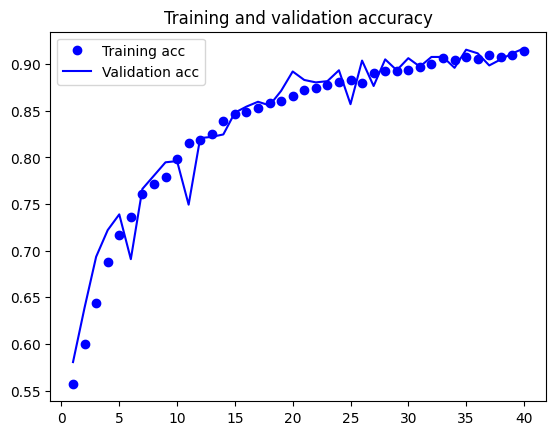

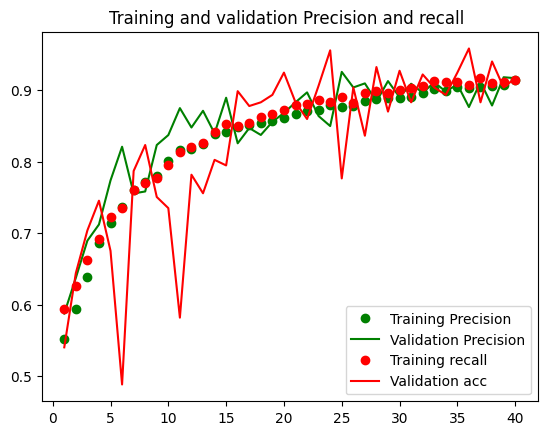

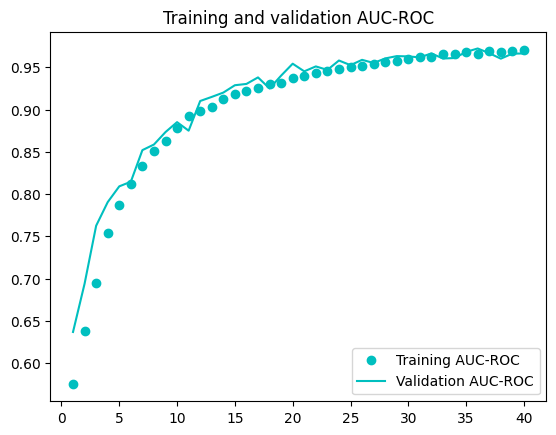

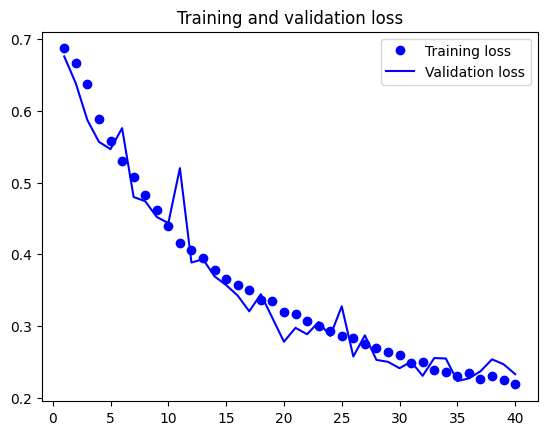

In [455]:
# modified from Deep Learning with Python book
import matplotlib.pyplot as plt
# accuracy
acc = history_eyepacsv2.history['acc']
val_acc = history_eyepacsv2.history['val_acc']
# loss
loss = history_eyepacsv2.history['loss']
val_loss = history_eyepacsv2.history['val_loss']

# precision
precision = history_eyepacsv2.history['precision_4']
val_precision = history_eyepacsv2.history['val_precision_4']

# recall
recall = history_eyepacsv2.history['recall_4']
val_recall = history_eyepacsv2.history['val_recall_4']

# auc-roc
auc = history_eyepacsv2.history['auc_4']
val_auc = history_eyepacsv2.history['val_auc_4']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'go', label='Training Precision')
plt.plot(epochs, val_precision, 'g', label='Validation Precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation acc')
plt.title('Training and validation Precision and recall ')
plt.legend()
plt.figure()

plt.plot(epochs, auc, 'co', label='Training AUC-ROC')
plt.plot(epochs, val_auc, 'c', label='Validation AUC-ROC')
plt.title('Training and validation AUC-ROC')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The validation lines are close to the training lines as the training progresses for almost all 4 metrics which indicates good fitting.

Now, lets test this model this on the testing data. I would expect similiar performance as the whole data is from one source.

In [456]:
# test data generator for test data from the test directory
test_eyepacs_generator = test_eyepacs_datagen.flow_from_directory(
        test_eyepacs_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 770 images belonging to 2 classes.


Now, lets predict and print out the metric-wise results

In [458]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = eyepacsv2_model.evaluate(test_eyepacs_generator, steps=24)
print("Accuracy on test dataset:", test_accuracy)
print("Precision on test dataset:", test_precision)
print("Recall (sensitivity) on test dataset:", test_recall)
print("AUC-ROC score on test dataset:", test_auc)


24/24 [==============================] - 2s 88ms/step - loss: 0.2540 - acc: 0.8945 - precision_4: 0.9081 - recall_4: 0.8773 - auc_4: 0.9640
Accuracy on test dataset: 0.89453125
Precision on test dataset: 0.908108115196228
Recall (sensitivity) on test dataset: 0.877284586429596
AUC-ROC score on test dataset: 0.9640364050865173


We can see good performance on the testing dataset as expected. The AUC-ROC score is high implying that the model is well distinguishing between glaucoma-positive and negative images. However, this score may be misleading in the context of unseen data as Glaucoma varies alot to different factors such as race, ethnicity etc. Thus, lets test it on an external dataset:VEIRC indian dataset.

In [88]:
test_external_dir = "/home/drmohammad/Downloads/test_india"


In [459]:
# generate processed images from external dataset
test_external_generator = test_eyepacs_datagen.flow_from_directory(
        test_external_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 102 images belonging to 2 classes.


It has a total of 102 images. But it should give a good understanding of the model's generalization performance.

In [460]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = eyepacsv2_model.evaluate(test_external_generator, steps=3)
print("Accuracy on external test dataset:", test_accuracy)
print("Precision on external test dataset:", test_precision)
print("Recall (sensitivity) on external test dataset:", test_recall)
print("AUC-ROC score on external test dataset:", test_auc)

3/3 [==============================] - 1s 370ms/step - loss: 2.9461 - acc: 0.2604 - precision_4: 0.4074 - recall_4: 0.1667 - auc_4: 0.2131
Accuracy on external test dataset: 0.2604166567325592
Precision on external test dataset: 0.40740740299224854
Recall (sensitivity) on external test dataset: 0.1666666716337204
AUC-ROC score on external test dataset: 0.21313132345676422


Wow. We can see huge degradation in performance. Very high loss with low accuracy, recall, precision and auc-roc score. This confirms my assumption that even though the model fit very nicely with the testing data, it did not generalize well due to not having seen data from multiple sources. This also confirms that Glaucoma is very biased to diversity.

Now, I will use the same CNN architecture to train on the full 5 datasets combined.

<h2>Training Custom CNN model on the combined dataset</h2>

In [464]:
# data augmentation configuration using rotation and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,)

In [465]:
# no data augmentation for validation and test data
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [466]:
# data augmentation generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 9683 images belonging to 2 classes.


In [467]:
# data reading for validation data
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 1331 images belonging to 2 classes.


In [410]:
# define convnet model with same number of layers as done before.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=3e-4), metrics=['acc', metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [411]:
# basic convnet from Deep Learning with Python book.
history = model.fit(
    train_generator,
    steps_per_epoch=302, # samples / batch size
    epochs=40,
    validation_data=validation_generator)

Epoch 1/40
302/302 [==============================] - 208s 685ms/step - loss: 0.6804 - acc: 0.5710 - precision: 0.5850 - recall: 0.6602 - auc: 0.5941 - val_loss: 0.6653 - val_acc: 0.6123 - val_precision: 0.7165 - val_recall: 0.5386 - val_auc: 0.6590
Epoch 2/40
302/302 [==============================] - 207s 684ms/step - loss: 0.6670 - acc: 0.5993 - precision: 0.6217 - recall: 0.6269 - auc: 0.6327 - val_loss: 0.6510 - val_acc: 0.6551 - val_precision: 0.6497 - val_recall: 0.8680 - val_auc: 0.6736
Epoch 3/40
302/302 [==============================] - 208s 687ms/step - loss: 0.6458 - acc: 0.6350 - precision: 0.6463 - recall: 0.6903 - auc: 0.6759 - val_loss: 0.6100 - val_acc: 0.6920 - val_precision: 0.6944 - val_recall: 0.8288 - val_auc: 0.7156
Epoch 4/40
302/302 [==============================] - 207s 685ms/step - loss: 0.6074 - acc: 0.6767 - precision: 0.6839 - recall: 0.7267 - auc: 0.7299 - val_loss: 0.6039 - val_acc: 0.6747 - val_precision: 0.6986 - val_recall: 0.7634 - val_auc: 0.7252


Looks like the results are way better. Lets plot it. 

In [412]:
# save model
model.save("good_model_all_data_including_fives_4 metrics.keras")

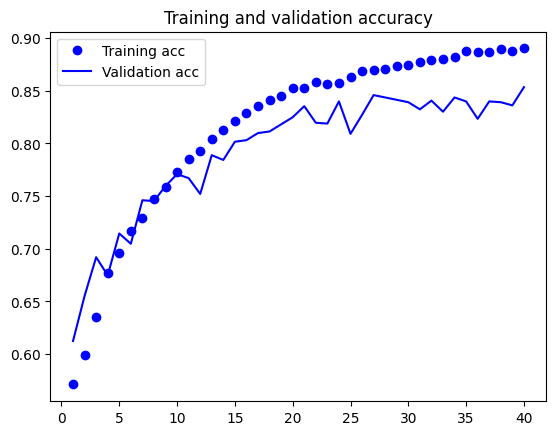

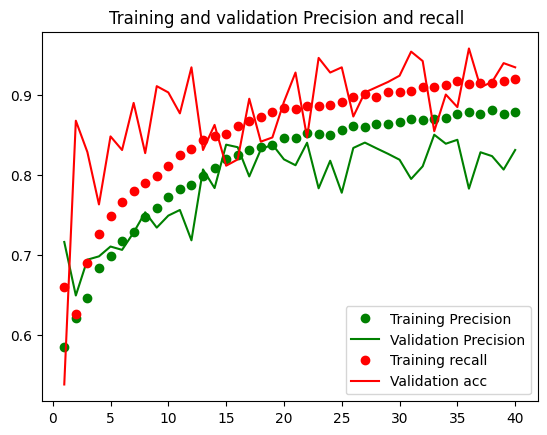

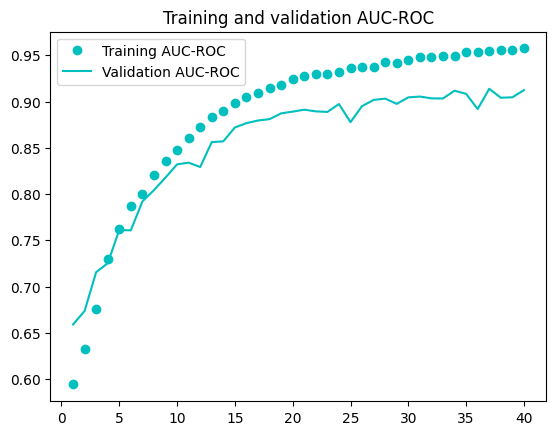

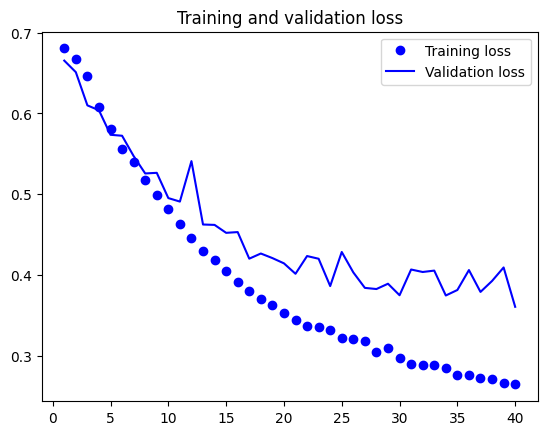

In [418]:
import matplotlib.pyplot as plt
# plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'go', label='Training Precision')
plt.plot(epochs, val_precision, 'g', label='Validation Precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation acc')
plt.title('Training and validation Precision and recall ')
plt.legend()
plt.figure()

plt.plot(epochs, auc, 'co', label='Training AUC-ROC')
plt.plot(epochs, val_auc, 'c', label='Validation AUC-ROC')
plt.title('Training and validation AUC-ROC')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We can see the model is starting to overfit. Lets see its performance on the internal testing data.

In [420]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 1331 images belonging to 2 classes.


In [428]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator, steps=41)
print("Accuracy on test dataset:", test_accuracy)
print("Precision on test dataset:", test_precision)
print("Recall (sensitivity) on test dataset:", test_recall)
print("AUC-ROC score on test dataset:", test_auc)


41/41 [==============================] - 4s 95ms/step - loss: 0.3640 - acc: 0.8460 - precision: 0.8191 - recall: 0.9405 - auc: 0.9144
Accuracy on test dataset: 0.8460366129875183
Precision on test dataset: 0.8191244006156921
Recall (sensitivity) on test dataset: 0.9404761791229248
AUC-ROC score on test dataset: 0.9143899083137512


The testing performance is lower than the earlier one. However, it is understandable considering the variety of data used for training and of the five datasets, some had less numbers and some had more. Now, the most interesting part is to see its performance on the external unseen data.

In [431]:
external_test_generator = test_datagen.flow_from_directory(
        "/home/drmohammad/Downloads/test_india/",
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 102 images belonging to 2 classes.


In [436]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(external_test_generator, steps=3)
print("Accuracy on external test dataset:", test_accuracy)
print("Precision on external test dataset:", test_precision)
print("Recall (sensitivity) on external test dataset:", test_recall)
print("AUC-ROC score on external test dataset:", test_auc)

3/3 [==============================] - 1s 359ms/step - loss: 0.5759 - acc: 0.7292 - precision: 0.7671 - recall: 0.8615 - auc: 0.7541
Accuracy on external test dataset: 0.7291666865348816
Precision on external test dataset: 0.767123281955719
Recall (sensitivity) on external test dataset: 0.8615384697914124
AUC-ROC score on external test dataset: 0.7540943026542664


Nice! We can see a highly improved performance suggesting that the use of multiple datasets is more beneficial towards achieving a generalized DL model.

Now, lets move on to more advanced techniques that could help us improve the performance. Transfer learning techniques are very commonly used for this purpose. Existing pre-trained networks can be finetuned with our own data to achieve higher performance. First, I will be using the EfficientNetB5 model with pre-trained imagenet weights:

<h2>Finetuning a pre-trained model (EfficientNet B5): Transfer learning approach</h2>

Let's re-process the dataset as efficientnet b5 takes 456 imagesize: 
https://www.tensorflow.org/tutorials/load_data/images AND https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [1]:
# define image size and batch
IMG_SIZE = 456
BATCH_SIZE = 32

In [93]:
# prepare training dataset from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=12,
  image_size=(456, 456),
  batch_size=32)

Found 9683 files belonging to 2 classes.


2024-02-13 18:50:24.868800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 18:50:24.870260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 18:50:24.870342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [94]:
# prepare validation dataset from directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
      seed=12,
  image_size=(456, 456),
  batch_size=32)

Found 1331 files belonging to 2 classes.


In [95]:
# prepare test dataset from directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
      seed=12,
  image_size=(456, 456),
  batch_size=32)

Found 1331 files belonging to 2 classes.


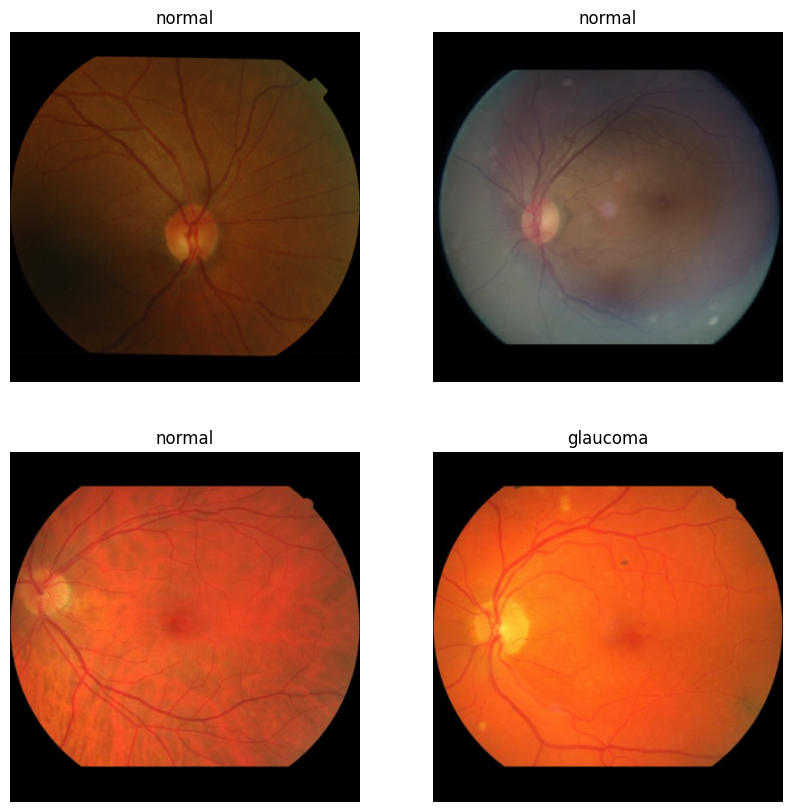

In [654]:
# plot 4 images from train dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [655]:
# print class names
class_names = train_ds.class_names
print(class_names)

['glaucoma', 'normal']


In [656]:
# image augmentation function
def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


In [657]:
# general function taken from: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [658]:
# used random rotation, flip, and contrast layers for augmentation
img_augmentation_layers = [
    layers.RandomRotation(factor=0.10),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

In [659]:
# changed from source for augmentation only as we dont need one-hot encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    
    return image, label


In [660]:
# augment training dataset and prefetch
train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [661]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
from tensorflow.keras.applications import EfficientNetB5
model = EfficientNetB5(weights='imagenet')

In [662]:
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB5(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    # used sigmoid to output probability of positive result only
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [663]:
# build model
model_efficientnet = build_model()

In [664]:
# train for 30 epochs
epochs = 30  # @param {type: "slider", min:8, max:80}
hist = model_efficientnet.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/30
303/303 [==============================] - 91s 274ms/step - loss: 0.9206 - accuracy: 0.6887 - val_loss: 0.5702 - val_accuracy: 0.7385
Epoch 2/30
303/303 [==============================] - 83s 269ms/step - loss: 0.7682 - accuracy: 0.7178 - val_loss: 0.6522 - val_accuracy: 0.7393
Epoch 3/30
303/303 [==============================] - 83s 269ms/step - loss: 0.6753 - accuracy: 0.7226 - val_loss: 0.5631 - val_accuracy: 0.7611
Epoch 4/30
303/303 [==============================] - 83s 270ms/step - loss: 0.6093 - accuracy: 0.7273 - val_loss: 0.5328 - val_accuracy: 0.7724
Epoch 5/30
303/303 [==============================] - 83s 270ms/step - loss: 0.5847 - accuracy: 0.7332 - val_loss: 0.5614 - val_accuracy: 0.7603
Epoch 6/30
303/303 [==============================] - 83s 270ms/step - loss: 0.5573 - accuracy: 0.7348 - val_loss: 0.5071 - val_accuracy: 0.7708
Epoch 7/30
303/303 [==============================] - 83s 270ms/step - loss: 0.5415 - accuracy: 0.7404 - val_loss: 0.5828 - val_ac

Epoch 1/100


2024-02-12 00:31:48.587217: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


303/303 [==============================] - 95s 285ms/step - loss: 0.4932 - accuracy: 0.7703 - precision_5: 0.7678 - recall_5: 0.8132 - auc_5: 0.8421 - val_loss: 0.4851 - val_accuracy: 0.7716 - val_precision_5: 0.7982 - val_recall_5: 0.8065 - val_auc_5: 0.8462
Epoch 2/100
303/303 [==============================] - 86s 278ms/step - loss: 0.4808 - accuracy: 0.7761 - precision_5: 0.7761 - recall_5: 0.8126 - auc_5: 0.8498 - val_loss: 0.4790 - val_accuracy: 0.7731 - val_precision_5: 0.7927 - val_recall_5: 0.8196 - val_auc_5: 0.8493
Epoch 3/100
303/303 [==============================] - 86s 279ms/step - loss: 0.4789 - accuracy: 0.7747 - precision_5: 0.7755 - recall_5: 0.8099 - auc_5: 0.8510 - val_loss: 0.4751 - val_accuracy: 0.7799 - val_precision_5: 0.7980 - val_recall_5: 0.8261 - val_auc_5: 0.8520
Epoch 4/100
303/303 [==============================] - 85s 279ms/step - loss: 0.4687 - accuracy: 0.7791 - precision_5: 0.7778 - recall_5: 0.8173 - auc_5: 0.8586 - val_loss: 0.4734 - val_accuracy: 

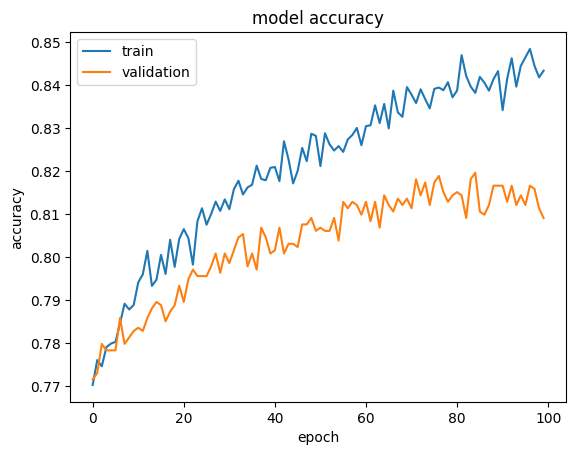

In [666]:
# as shown in: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# and added the needed metrics
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", metrics.Precision(), metrics.Recall(), metrics.AUC()]
    )


unfreeze_model(model_efficientnet)

# train for 100 epochs
epochs = 100  
hist = model_efficientnet.fit(train_ds, epochs=epochs, validation_data=val_ds)
plot_hist(hist)

Let's plot the results.

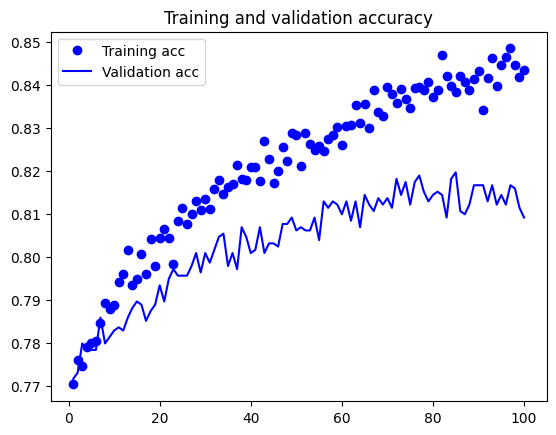

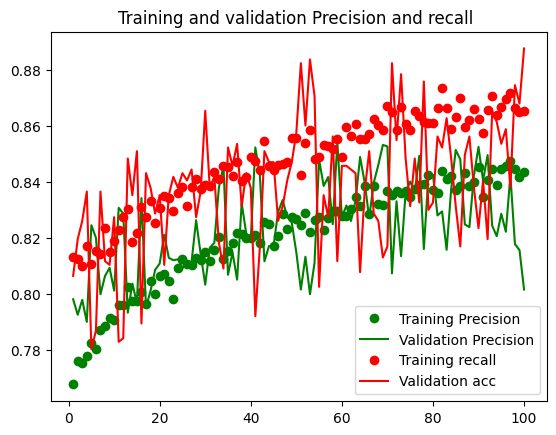

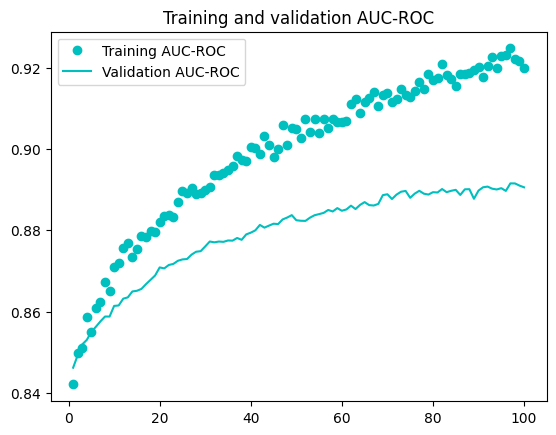

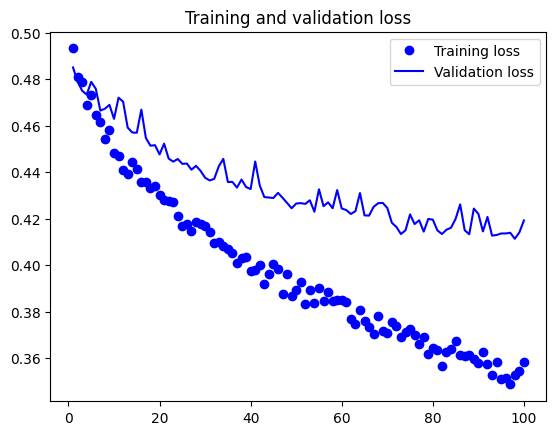

In [669]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

precision = hist.history['precision_5']
val_precision = hist.history['val_precision_5']

recall = hist.history['recall_5']
val_recall = hist.history['val_recall_5']

auc = hist.history['auc_5']
val_auc = hist.history['val_auc_5']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'go', label='Training Precision')
plt.plot(epochs, val_precision, 'g', label='Validation Precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation acc')
plt.title('Training and validation Precision and recall ')
plt.legend()
plt.figure()

plt.plot(epochs, auc, 'co', label='Training AUC-ROC')
plt.plot(epochs, val_auc, 'c', label='Validation AUC-ROC')
plt.title('Training and validation AUC-ROC')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, lets see the performance on internal testing data.

In [670]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_efficientnet.evaluate(test_ds)
print("Accuracy on test dataset:", test_accuracy)
print("Precision on test dataset:", test_precision)
print("Recall (sensitivity) on test dataset:", test_recall)
print("AUC-ROC score on test dataset:", test_auc)

42/42 [==============================] - 10s 231ms/step - loss: 0.4222 - accuracy: 0.8174 - precision_5: 0.8085 - recall_5: 0.8941 - auc_5: 0.8848
Accuracy on test dataset: 0.8174304962158203
Precision on test dataset: 0.8085106611251831
Recall (sensitivity) on test dataset: 0.8941176533699036
AUC-ROC score on test dataset: 0.884819507598877


We get a better test performance using the finetuned EfficientNetB5 model. Lets see the performance on the external testing dataset.

In [6]:
external_ds = tf.keras.utils.image_dataset_from_directory(
  external_test_dir,
      seed=12,
  image_size=(456, 456),
  batch_size=32)

Found 102 files belonging to 2 classes.


2024-02-19 22:58:07.365280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 22:58:07.375971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 22:58:07.376128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [674]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_efficientnet.evaluate(external_ds)
print("Accuracy on external test dataset:", test_accuracy)
print("Precision on external test dataset:", test_precision)
print("Recall (sensitivity) on external test dataset:", test_recall)
print("AUC-ROC score on external test dataset:", test_auc)

4/4 [==============================] - 1s 194ms/step - loss: 0.3730 - accuracy: 0.8235 - precision_5: 0.8824 - recall_5: 0.8571 - auc_5: 0.9161
Accuracy on external test dataset: 0.8235294222831726
Precision on external test dataset: 0.8823529481887817
Recall (sensitivity) on external test dataset: 0.8571428656578064
AUC-ROC score on external test dataset: 0.9160714149475098


Wow! we can see a sensitivity of 0.86 on the totally unseen external dataset indicating signs of improved performance.

In [675]:
# save model
model_efficientnet.save("efficientnet_b5_good.keras")

<h2>Finetuning a Vision Transformer pretrained model</h2>

Now, lets use a recent state-of-the-art Vision Transformer architecture for training a pre-trained model that is known to be performing well in the recent days. It accepts smaller image size due to its architecture. The code that I am using is derivated from: https://huggingface.co/blog/fine-tune-vit

In [47]:
# import functions for loading dataset
from datasets import load_dataset, DatasetDict

I combined all data (5 datasets) from the earlier folder that I used for the training above into one folder that contains a single folder called train due to datasets library's load_dataset function requirements. This was done manually.

In [67]:
# load a combined dataset
ds_path = "/home/drmohammad/Documents/final-glaucoma/data_combined"
dataset = load_dataset("imagefolder", data_dir=ds_path)

Resolving data files:   0%|          | 0/12345 [00:00<?, ?it/s]

In [68]:
# take 80% from folder as training
train_testvalid = dataset["train"].train_test_split(test_size=0.2)

In [69]:
# split test 20% into two parts for validation and testing
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

In [70]:
# https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2
final_ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})

In [71]:
final_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9876
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1235
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1234
    })
})

In [72]:
# use google/vit-base-patch16-224-in21k as base model
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [73]:
# check what preprocessing is to be applied
print(processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [74]:
# process all images and convert to tensors
def transform(batch):
    inputs = processor([x for x in batch['image']], return_tensors='pt')

    inputs['label'] = batch['label']
    return inputs

In [75]:
# this ensures that the images are processed when needed only
processed_ds = final_ds.with_transform(transform)

In [76]:
processed_ds['train'][0:2]

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1

In [77]:
import torch
# collate function is used to create a batch size
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [80]:
# computer_metrics function for defining the four metrics that I am using for this project
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    auc_roc = roc_auc_score(labels, preds)
    return {'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'auc_roc':auc_roc }

In [81]:
from transformers import ViTForImageClassification

# get data labels
labels = final_ds['train'].features['label'].names

# instantiate model 
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
from transformers import TrainingArguments

# training parameters for ViT
training_args = TrainingArguments(
  output_dir="./vit-base-glaucoma",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [85]:
from transformers import Trainer

# define Trainer that will combine all that was done above for an easy way for training and evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_ds["train"],
    eval_dataset=processed_ds["validation"],
    tokenizer=processor,
)

In [86]:
# train
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,Auc Roc
100,0.631100,0.689823,0.670989,0.723155,0.670989,0.653315
200,0.575400,0.499002,0.777958,0.778151,0.777958,0.775113
300,0.476000,0.457396,0.793355,0.807299,0.793355,0.785172
400,0.467700,0.433998,0.813614,0.814178,0.813614,0.810809
500,0.362900,0.413228,0.818476,0.821499,0.818476,0.820320
600,0.456600,0.405652,0.826580,0.842224,0.826580,0.818685
700,0.367700,0.390203,0.828201,0.829505,0.828201,0.829055
800,0.350000,0.399887,0.833874,0.848742,0.833874,0.826264
900,0.297900,0.361496,0.850081,0.853052,0.850081,0.846137
1000,0.307000,0.377104,0.857374,0.862994,0.857374,0.852482


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2851005231GF
  train_loss               =       0.3005
  train_runtime            =   0:08:21.24
  train_samples_per_second =       78.811
  train_steps_per_second   =        4.932


I tried training for more epochs but it was overfitting. Thus, I had to keep it at 4 epochs. Let's see the performance on the internal testing set.

In [87]:
metrics = trainer.evaluate(processed_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.864
  eval_auc_roc            =     0.8608
  eval_loss               =     0.3953
  eval_precision          =     0.8646
  eval_recall             =      0.864
  eval_runtime            = 0:00:07.27
  eval_samples_per_second =    169.833
  eval_steps_per_second   =     21.315


It is showing similiar testing performance to the EfficientNetB5 model as well. Let's see the performance on the external dataset.

In [89]:
external_testing_ds = load_dataset("imagefolder", data_dir=test_external_dir)

Resolving data files:   0%|          | 0/102 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [90]:
external_testing_ds_processed = external_testing_ds.with_transform(transform)

In [91]:
metrics = trainer.evaluate(external_testing_ds_processed['train'])
trainer.log_metrics("external eval", metrics)
trainer.save_metrics("external eval", metrics)

***** external eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8235
  eval_auc_roc            =     0.7781
  eval_loss               =     0.5584
  eval_precision          =     0.8196
  eval_recall             =     0.8235
  eval_runtime            = 0:00:03.08
  eval_samples_per_second =      33.04
  eval_steps_per_second   =      4.211


The accuracy is fine, however the AUC-ROC score is a bit low. Till now, the EfficientNetB5 model is showing the best overall performance in terms of generalization.

<h2>VGG16</h2>

I followed the book: Deep Learning with Python for implementing VGG16 finetuning.

In [62]:
# data augmentation configuration using rotation and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,)

In [63]:
# no data augmentation for validation and test data
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [64]:
# data augmentation generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 9683 images belonging to 2 classes.


In [65]:
# data reading for validation data
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 1331 images belonging to 2 classes.


In [66]:
from keras.applications import VGG16

In [67]:
# used imagenet pretrained weights for base model.
base_model = VGG16(weights='imagenet', include_top = False, input_shape = (512, 512, 3))

In [68]:
# see a summary of the base model layers
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [69]:
# define custom convnet model by starting with the VGG16 base model
# The base model will be freezed first and the last two dense layers will
# be used for training only
vgg_model = models.Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))

In [70]:
# freeze base model
base_model.trainable = False

In [71]:
len(vgg_model.trainable_weights)

4

In [73]:
# compile model with initial 3e-5 learning rate
vgg_model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=3e-5), metrics=['acc', metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [74]:
# train VGG16 custom by using the two extra added dense layers
history_vgg_model = vgg_model.fit(
    train_generator,
    steps_per_epoch=302, # samples / batch size
    epochs=30,
    validation_data=validation_generator)

Epoch 1/30
302/302 [==============================] - 219s 724ms/step - loss: 0.7301 - acc: 0.6147 - precision_5: 0.6360 - recall_5: 0.6413 - auc_5: 0.6518 - val_loss: 0.7986 - val_acc: 0.5252 - val_precision_5: 0.8556 - val_recall_5: 0.2092 - val_auc_5: 0.7755
Epoch 2/30
302/302 [==============================] - 216s 714ms/step - loss: 0.6382 - acc: 0.6680 - precision_5: 0.6851 - recall_5: 0.6937 - auc_5: 0.7247 - val_loss: 0.7803 - val_acc: 0.6266 - val_precision_5: 0.6075 - val_recall_5: 0.9895 - val_auc_5: 0.7925
Epoch 3/30
302/302 [==============================] - 215s 713ms/step - loss: 0.6074 - acc: 0.6879 - precision_5: 0.7023 - recall_5: 0.7157 - auc_5: 0.7536 - val_loss: 0.5757 - val_acc: 0.7235 - val_precision_5: 0.6914 - val_recall_5: 0.9373 - val_auc_5: 0.7983
Epoch 4/30
302/302 [==============================] - 215s 712ms/step - loss: 0.5875 - acc: 0.6968 - precision_5: 0.7085 - recall_5: 0.7284 - auc_5: 0.7652 - val_loss: 0.5910 - val_acc: 0.6657 - val_precision_5: 0.

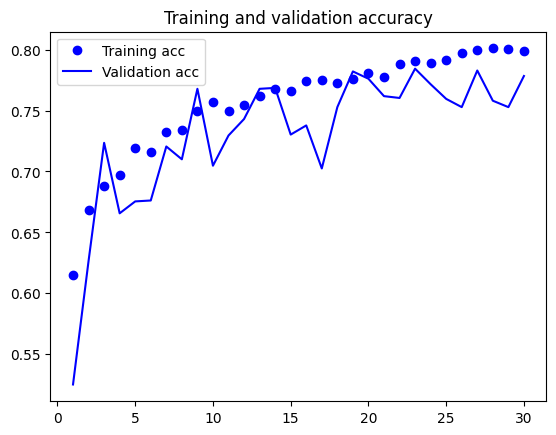

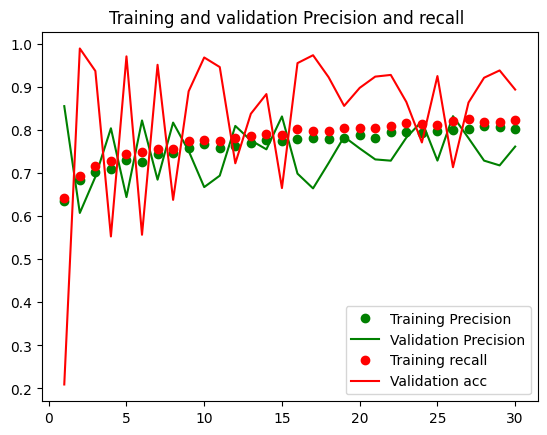

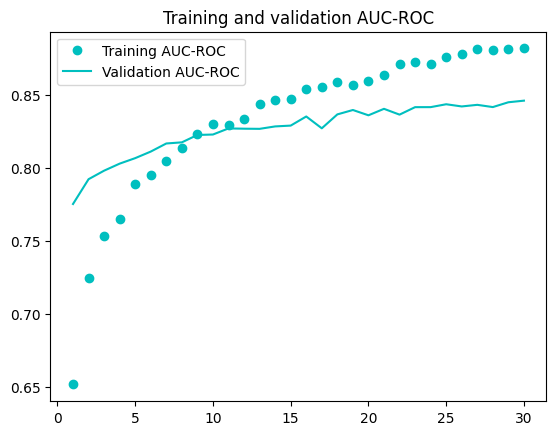

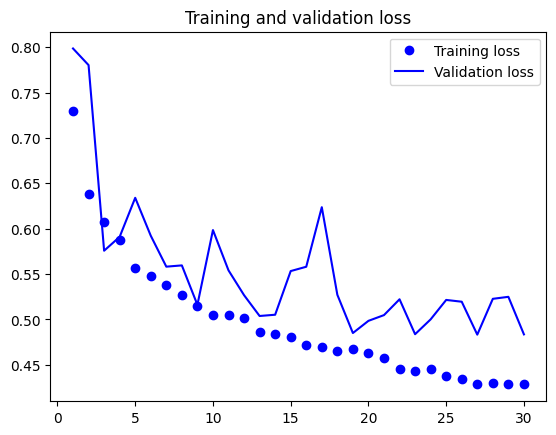

In [76]:
import matplotlib.pyplot as plt
# plot results
acc = history_vgg_model.history['acc']
val_acc = history_vgg_model.history['val_acc']
loss = history_vgg_model.history['loss']
val_loss = history_vgg_model.history['val_loss']

precision = history_vgg_model.history['precision_5']
val_precision = history_vgg_model.history['val_precision_5']

recall = history_vgg_model.history['recall_5']
val_recall = history_vgg_model.history['val_recall_5']

auc = history_vgg_model.history['auc_5']
val_auc = history_vgg_model.history['val_auc_5']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'go', label='Training Precision')
plt.plot(epochs, val_precision, 'g', label='Validation Precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation acc')
plt.title('Training and validation Precision and recall ')
plt.legend()
plt.figure()

plt.plot(epochs, auc, 'co', label='Training AUC-ROC')
plt.plot(epochs, val_auc, 'c', label='Validation AUC-ROC')
plt.title('Training and validation AUC-ROC')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, lets unfreeze the top 4 layers of the VGG16 base model (block 5) and train on them.

In [77]:
# unfreeze the base model
base_model.trainable = True

In [78]:
# freeze all layers below block 5
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [79]:
len(vgg_model.trainable_weights)

10

In [82]:
# compile again
vgg_model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=1e-6), metrics=['acc', metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [83]:
# train for 30 epochs
history_vgg_model = vgg_model.fit(
    train_generator,
    steps_per_epoch=302, # samples / batch size
    epochs=30,
    validation_data=validation_generator)

Epoch 1/30
302/302 [==============================] - 222s 732ms/step - loss: 0.3782 - acc: 0.8300 - precision_7: 0.8315 - recall_7: 0.8521 - auc_7: 0.9128 - val_loss: 0.4794 - val_acc: 0.7799 - val_precision_7: 0.8065 - val_recall_7: 0.8118 - val_auc_7: 0.8502
Epoch 2/30
302/302 [==============================] - 217s 717ms/step - loss: 0.3714 - acc: 0.8315 - precision_7: 0.8335 - recall_7: 0.8534 - auc_7: 0.9155 - val_loss: 0.4810 - val_acc: 0.7821 - val_precision_7: 0.7666 - val_recall_7: 0.8928 - val_auc_7: 0.8502
Epoch 3/30
302/302 [==============================] - 215s 712ms/step - loss: 0.3676 - acc: 0.8373 - precision_7: 0.8392 - recall_7: 0.8581 - auc_7: 0.9173 - val_loss: 0.4835 - val_acc: 0.7791 - val_precision_7: 0.7637 - val_recall_7: 0.8915 - val_auc_7: 0.8508
Epoch 4/30
302/302 [==============================] - 216s 715ms/step - loss: 0.3604 - acc: 0.8397 - precision_7: 0.8399 - recall_7: 0.8627 - auc_7: 0.9203 - val_loss: 0.4747 - val_acc: 0.7866 - val_precision_7: 0.

Lets plot the results.

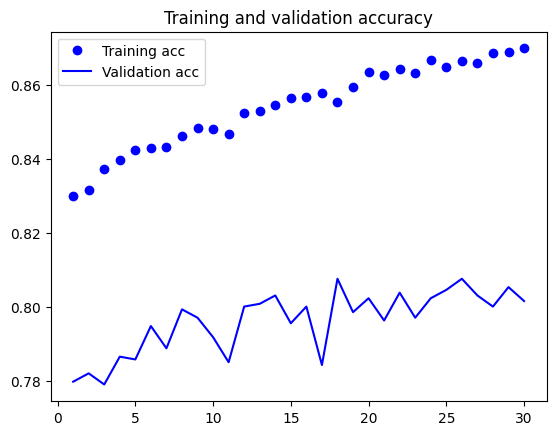

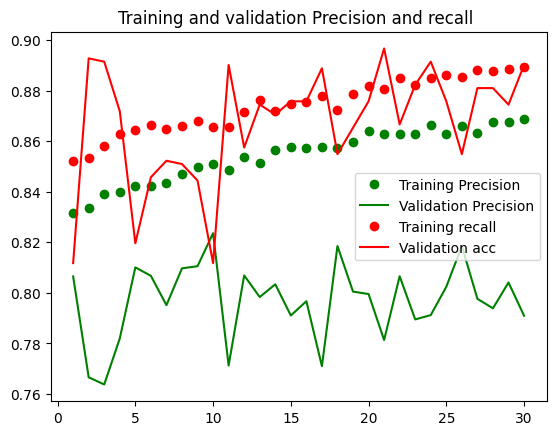

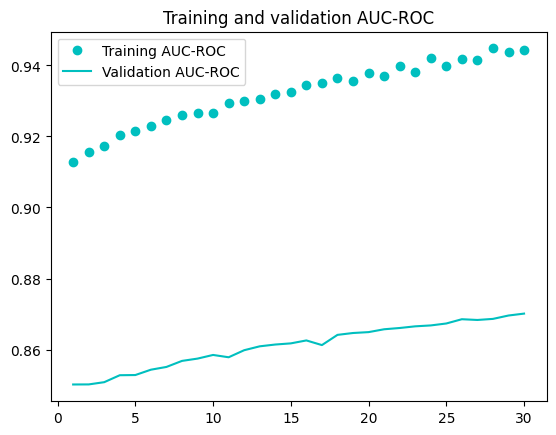

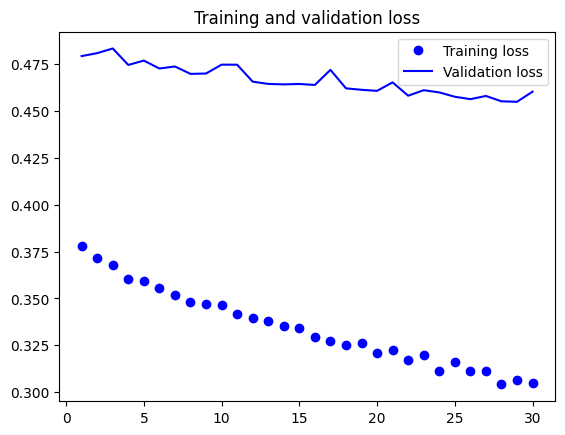

In [84]:
import matplotlib.pyplot as plt
# plot results
acc = history_vgg_model.history['acc']
val_acc = history_vgg_model.history['val_acc']
loss = history_vgg_model.history['loss']
val_loss = history_vgg_model.history['val_loss']

precision = history_vgg_model.history['precision_7']
val_precision = history_vgg_model.history['val_precision_7']

recall = history_vgg_model.history['recall_7']
val_recall = history_vgg_model.history['val_recall_7']

auc = history_vgg_model.history['auc_7']
val_auc = history_vgg_model.history['val_auc_7']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'go', label='Training Precision')
plt.plot(epochs, val_precision, 'g', label='Validation Precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation acc')
plt.title('Training and validation Precision and recall ')
plt.legend()
plt.figure()

plt.plot(epochs, auc, 'co', label='Training AUC-ROC')
plt.plot(epochs, val_auc, 'c', label='Validation AUC-ROC')
plt.title('Training and validation AUC-ROC')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Not much improvement for 30 epochs. A raise of ~4% for each metric is noticed. I did not train for more epochs as it was overfitting.

In [87]:
# save model
vgg_model.save("vgg_combined_dataset.keras")

Lets start by internal testing.

In [85]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 1331 images belonging to 2 classes.


In [86]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = vgg_model.evaluate(test_generator, steps=41)
print("Accuracy on test dataset:", test_accuracy)
print("Precision on test dataset:", test_precision)
print("Recall (sensitivity) on test dataset:", test_recall)
print("AUC-ROC score on test dataset:", test_auc)


41/41 [==============================] - 8s 185ms/step - loss: 0.4903 - acc: 0.7835 - precision_7: 0.7735 - recall_7: 0.8821 - auc_7: 0.8438
Accuracy on test dataset: 0.7835366129875183
Precision on test dataset: 0.7735191583633423
Recall (sensitivity) on test dataset: 0.8821191787719727
AUC-ROC score on test dataset: 0.8437846899032593


We can see that the performance of the VGG-16 finetuned model on the internal testing set is lower than that of ViT and EfficientNetB5. Lets see the performance on the external testing set.

In [88]:
external_test_generator = test_datagen.flow_from_directory(
        "/home/drmohammad/Downloads/test_india/",
        target_size=(512, 512),
        batch_size=32,
        class_mode='binary')

Found 102 images belonging to 2 classes.


In [89]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = vgg_model.evaluate(external_test_generator, steps=3)
print("Accuracy on external test dataset:", test_accuracy)
print("Precision on external test dataset:", test_precision)
print("Recall (sensitivity) on external test dataset:", test_recall)
print("AUC-ROC score on external test dataset:", test_auc)

3/3 [==============================] - 1s 378ms/step - loss: 1.1558 - acc: 0.6771 - precision_7: 0.6813 - recall_7: 0.9688 - auc_7: 0.6248
Accuracy on external test dataset: 0.6770833134651184
Precision on external test dataset: 0.6813187003135681
Recall (sensitivity) on external test dataset: 0.96875
AUC-ROC score on external test dataset: 0.624755859375


We can see that it did not generalize well. Maybe further hyperparameter tuning should be able to increase it a bit more. Thus, we can say that the best-performing model till now is the finetuned EfficientNetB5 model. Now, lets add a feature for implementing explainability to the EfficientNet model. This will allow understanding of the reasoning for diagnosing a Glaucoma-positive image as positive.

<h2>Explainability for Glaucoma prediction on the EfficientNetB5 fine-tuned model</h2>

In [5]:
# load model
effiecient_net_model = tf.keras.models.load_model('efficientnet_b5_good.keras')

2024-02-19 23:04:22.220471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 23:04:22.232534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 23:04:22.232642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

First, I will evaluate the performance of the EfficientNetB5 model on the external dataset using a detailed analysis.

In [6]:
# prepare external dataset
external_ds = tf.keras.utils.image_dataset_from_directory(
  external_test_dir,
      seed=12,
  image_size=(456, 456),
  batch_size=32)

Found 102 files belonging to 2 classes.


In [7]:
# use the external dataset for evaluation
eval_dataset = external_ds

# initialize numpy arrays for storing predicted and actual labels
y_pred = np.array([])
y_true =  np.array([])

for x, y in eval_dataset:
    Y_pred = effiecient_net_model(x)
    # get the class using a threshold as the output is from a sigmoid activation function
    pred_class = [1 if pred > 0.5 else 0 for pred in Y_pred]
    y_pred = np.concatenate([y_pred, pred_class])
    y_true = np.concatenate([y_true, y])

2024-02-19 23:04:59.102736: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


Confusion Matrix


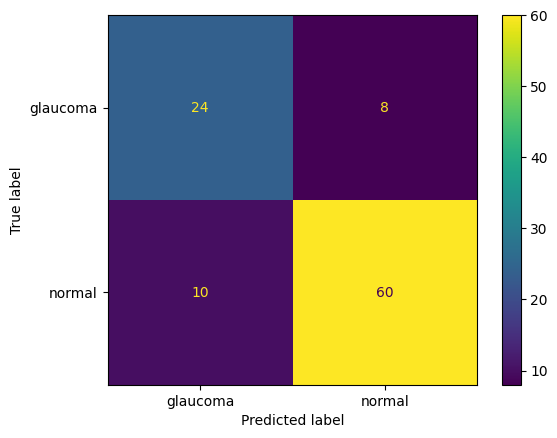

In [8]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eval_dataset.class_names)
disp.plot()

Let's see a classwise classification report.

In [9]:
print(classification_report(y_true, y_pred, target_names=list(eval_dataset.class_names)))

              precision    recall  f1-score   support

    glaucoma       0.71      0.75      0.73        32
      normal       0.88      0.86      0.87        70

    accuracy                           0.82       102
   macro avg       0.79      0.80      0.80       102
weighted avg       0.83      0.82      0.82       102



We can see that the recall for diagnosing glaucoma-positive image as positive is 0.75. Now lets use LIME: a black-box model explanation algorithm. The code is modified from: https://coderzcolumn.com/tutorials/artificial-intelligence/lime-explain-keras-image-classification-network-predictions#google_vignette

In [528]:
from lime import lime_image
tf.random.set_seed(1234)

In [529]:
# for enabling reshape
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [530]:
# instantiate explainer
explainer = lime_image.LimeImageExplainer(random_state=123)

In [531]:
import skimage

# function for getting the output of the model prediction in 0,1 format
def make_prediction(img):
    # check for making sure that the image input is in 4D
    if img.ndim != 4:
        img = np.expand_dims(img, axis=0)
    preds = effiecient_net_model.predict(img)
    pred = [[1] if pred > 0.5 else [0] for pred in preds]
    return pred

In [532]:
# get the first batch and extract images and labels
first_batch = eval_dataset.take(1)
images, labels = list(first_batch)[0]

In [533]:
# get first Glaucoma-positive label
index = 0
for i, label in enumerate(labels):
    # check actual value is positive
    if int(label.numpy()) == 1:
        # get predicted value
        pred = make_prediction(images[i].numpy().astype("uint8"))
        print(pred)
        # check predicted value is positive
        if pred[0][0] == 1:
            index = i
            # finish
            break

1/1 [==============================] - 1s 758ms/step
[[1]]


In [534]:
# train local surrogate model
explanation = explainer.explain_instance(images[index].numpy().astype("uint8"), make_prediction, random_seed=123, top_labels=1,num_samples=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


In [541]:
# get image and mask for LIME explanation
img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

In [542]:
from skimage.segmentation import mark_boundaries

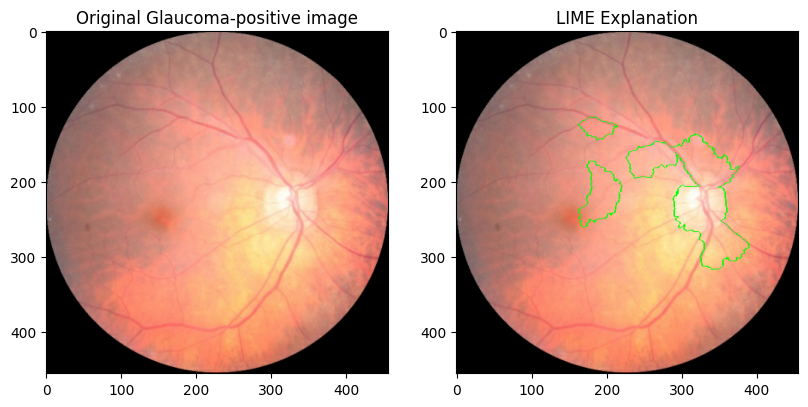

In [544]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images[i].numpy().astype("uint8"))
plt.title(f"Original Glaucoma-positive image")
plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(img, mask, color=(0,1,0)))
plt.title("LIME Explanation")
plt.show()

Hooray, we can see the optical disk being shown as reasoning for the image being Glaucoma-positive.